# Omar Hamoudeh
# Programming Exercise \#3
---

# Preamble

In [781]:
# import relevant Python libraries

import numpy as np
import pandas as pd
from scipy import stats as sps
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, Latex


# **1. Noise Level Classification Using Plug-in Classifiers**

## 1.1

### (a)

In [782]:
### Your code for 1.1(a) goes here ###

# Loading the training dataset
trainingDF = pd.read_csv('NoiseClassificationTrainingData.csv')

mean = trainingDF.groupby('ClassLabel').mean()

squaredSum = 0
for sample in trainingDF.itertuples():
    squaredSum += (sample[1] - mean.loc[sample[2]]['NoiseLevel']) ** 2

commonVariance = squaredSum/400

print('ML Estimate For The Means: ')
display(mean)
print('ML Estimate For The Common Variance: ')
print(commonVariance)


ML Estimate For The Means: 


,NoiseLevel
ClassLabel,
0.0,44.656310
1.0,55.277232
2.0,64.886901


ML Estimate For The Common Variance: 
11.995287584605006


### (b)

By default, the numpy.var() function returns the MLE of the variance. According to the numpy documentation, numpy.var() returns the sum of the squared differences divided by (N - ddof). ddof, or 'Delta Degrees of Freedom', has a default value of 0 if not defined, resulting in the MLE of the variance. If you want the unbiased estimate for variance, you would need to set ddof = 1.

## 1.2

### (a)

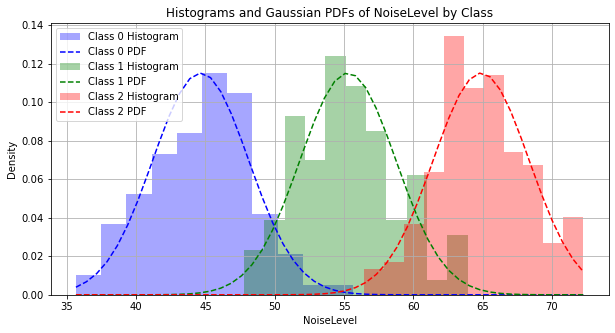

In [783]:
### Your code for 1.2 goes here ###
classes = [0, 1, 2]
colors = ['blue', 'green', 'red']
plt.figure(figsize=(10, 5))

for cls, color in zip(classes, colors):
    classData = trainingDF[trainingDF['ClassLabel'] == cls]['NoiseLevel']
    
    plt.hist(classData, bins=11, alpha=0.35, density=True, color=color, label=f'Class {cls} Histogram')
    
    xValues = np.linspace(min(trainingDF['NoiseLevel']), max(trainingDF['NoiseLevel']))
    pdfValues = sps.norm.pdf(xValues, loc=mean.loc[cls], scale=np.sqrt(commonVariance))
    plt.plot(xValues, pdfValues, color=color, linestyle='--', label=f'Class {cls} PDF')

plt.xlabel('NoiseLevel')
plt.ylabel('Density')
plt.title('Histograms and Gaussian PDFs of NoiseLevel by Class')
plt.legend()
plt.grid(True)

plt.show()


### (b)

Based on the histograms and the overlayed Guassian PDFs, I believe that the Guassian distribution with different means and a shared variance is indeed a reasonable assumption to make.  
From the plot, one can see that the guassian PDFs fit the histograms quite well.

## 1.3

In [784]:
### Your code for 1.3 goes here ###

class0 = 0
class1 = 0
class2 = 0
error = 0

for sample in trainingDF.itertuples():
    if sample.ClassLabel == 0: class0 += 1
    elif sample.ClassLabel == 1: class1 += 1
    elif sample.ClassLabel == 2: class2 += 1
    else: error += 1

Pr0 = class0/400
Pr1 = class1/400
Pr2 = class2/400

print('Prior Probabilities: \n')
print('Pr(class=0) = ', Pr0)
print('Pr(class=1) = ', Pr1)
print('Pr(class=2) = ', Pr2)

Prior Probabilities: 

Pr(class=0) =  0.2625
Pr(class=1) =  0.22
Pr(class=2) =  0.5175


## 1.4

In [820]:
### Your code for 1.4 goes here ###

def likelihood0(noiseLevel): return np.exp( -0.5 * ((noiseLevel - mean.loc[0]['NoiseLevel']) ** 2) / commonVariance)
def likelihood1(noiseLevel): return np.exp( -0.5 * ((noiseLevel - mean.loc[1]['NoiseLevel']) ** 2) / commonVariance)
def likelihood2(noiseLevel): return np.exp( -0.5 * ((noiseLevel - mean.loc[2]['NoiseLevel']) ** 2) / commonVariance)

lossMatrix = np.array([
    [-1, 2, 4],  # True class 0
    [ 2, 0, 4],   # True class 1
    [ 4, 4, 0]    # True class 2
])

def MLClassifier(noiseLevel):
    return np.argmax([likelihood0(noiseLevel), likelihood1(noiseLevel), likelihood2(noiseLevel)])

def MAPClassifier(noiseLevel):
    return np.argmax([Pr0 * likelihood0(noiseLevel), Pr1 * likelihood1(noiseLevel), Pr2 * likelihood2(noiseLevel)])

def BayesClassifier(noiseLevel):
    def calculateRisk(noiseLevel):
        # Likelihoods weighted by there prior probabilities
        likelihoods = [
            Pr0 * likelihood0(noiseLevel),
            Pr1 * likelihood1(noiseLevel),
            Pr2 * likelihood2(noiseLevel)
        ]

        risks = [] # This will hold the risk of chosing each class
        for j in range(len(likelihoods)):
            risk = 0 # The risk for class j
            for i in range(len(likelihoods)):
                risk += lossMatrix[i,j] * likelihoods[i]
            risks.append(risk)
        return risks
    return np.argmin(calculateRisk(noiseLevel))

def evaluateClassifier(df, predictedLabelColumn):

    classCounts = df[predictedLabelColumn].value_counts()
    for cls in range(3):
        print(f'Classified as Class {cls}: {classCounts.get(cls)} samples')
    
    for groundTruth in range(3):
        correctlyClassified = df[(df['ClassLabel'] == groundTruth) & (df[predictedLabelColumn] == groundTruth)].shape[0]
        totalSamples = df[df['ClassLabel'] == groundTruth].shape[0]
        print(f'Class {groundTruth}: {correctlyClassified} out of {totalSamples} correctly classified')

# Loading the test dataset
testDF = pd.read_csv('NoiseClassificationTestData.csv')

# Make Predictions
testDF['MLPredict'] = testDF['NoiseLevel'].apply(MLClassifier)
testDF['MAPPredict'] = testDF['NoiseLevel'].apply(MAPClassifier)
testDF['BayesPredict'] = testDF['NoiseLevel'].apply(BayesClassifier)
    
# Evaluate each classifiers predictions
print('ML Classifier:')
evaluateClassifier(testDF, 'MLPredict')
print('\nMAP Classifier:')
evaluateClassifier(testDF, 'MAPPredict')
print('\nPlug-in Bayes Classifier for a General Loss Function:')
evaluateClassifier(testDF, 'BayesPredict')



ML Classifier:
Classified as Class 0: 22 samples
Classified as Class 1: 28 samples
Classified as Class 2: 50 samples
Class 0: 21 out of 27 correctly classified
Class 1: 21 out of 22 correctly classified
Class 2: 50 out of 51 correctly classified

MAP Classifier:
Classified as Class 0: 23 samples
Classified as Class 1: 25 samples
Classified as Class 2: 52 samples
Class 0: 22 out of 27 correctly classified
Class 1: 20 out of 22 correctly classified
Class 2: 51 out of 51 correctly classified

Plug-in Bayes Classifier for a General Loss Function:
Classified as Class 0: 26 samples
Classified as Class 1: 22 samples
Classified as Class 2: 52 samples
Class 0: 25 out of 27 correctly classified
Class 1: 20 out of 22 correctly classified
Class 2: 51 out of 51 correctly classified


## 1.5

### (a)

In [786]:
### Your code for 1.5(a) goes here ###

def zeroOneLoss(df, predictedLabelColumn):
    incorrectPredictions = (df['ClassLabel'] != df[predictedLabelColumn]).sum()
    return incorrectPredictions / len(df)

# Evaluate 0/1 loss for each classifier
print('0/1 Loss For')
print('ML Classifier:', zeroOneLoss(testDF, 'MLPredict'))
print('MAP Classifier:', zeroOneLoss(testDF, 'MAPPredict'))
print('Bayes Classifier:', zeroOneLoss(testDF, 'BayesPredict'))

0/1 Loss For
ML Classifier: 0.08
MAP Classifier: 0.07
Bayes Classifier: 0.04


### (b)

In [819]:
### Your code for 1.5(b) goes here ###

def averageLoss(df, predictedLabelColumn):
    totalLoss = 0
    for label in range(3):
        for predicted in range(3):
            totalLoss += lossMatrix[label][predicted] * (df[(df['ClassLabel'] == label) & (df[predictedLabelColumn] == predicted)].shape[0])
    return totalLoss / 100

print('Average Loss For')
print('ML Classifer:', averageLoss(testDF, 'MLPredict'))
print('MAP Classifer:', averageLoss(testDF, 'MAPPredict'))
print('Bayes Classifer:', averageLoss(testDF, 'BayesPredict'))


Average Loss For
ML Classifer: -0.03
MAP Classifer: -0.06
Bayes Classifer: -0.15


## 1.6

### (a)

The `MAP classifier` is theoretically designed to minimize the expected 0/1 loss.

### (b)

The `plug in Bayes classifier` is theoretically designed to minimize the expected general loss.

### (c)

The empirical results reported in the previous question do not fully align with the theoretical guarantees.

For Part (a), the theoretical expectation is that the MAP classifier should have the lowest 0/1 loss. However, in the observed results, the plug-in Bayes classifier outperformed the MAP classifier, contradicting the theoretical predictions.

In contrast, in Part (b), the empirical results align with the theoretical expectations: the Bayes classifier achieved the lowest empirical risk, outperforming both the MAP and ML classifiers as expected.

### (d)

The empirical results may not align with the theoretical guarentess because of the relatively small sample sizes in both the training and test data sets.  

As the sizes of the training and test data sets increase, the law of large numbers ensures that these theoretical guarentees are indeed fufilled.  

This is because, with larger sample sizes, the estimates of probabilities, likelihoods, and priors become more accurate, reducing the variability in model performance. As a result, the classifiers' empirical behavior will converge to their theoretical expectations, minimizing the discrepancies caused by sampling noise and estimation errors present in smaller datasets.
